In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from tqdm import tqdm
from mendeleev.fetch import fetch_table
from seaborn_fig2grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec


sns.set_style('whitegrid')
%matplotlib inline

sys.path.append(str(Path().resolve().parent))
Path("plots/proxy_loss").mkdir(parents=True, exist_ok=True)

In [2]:
from dave import prepare_for_gfn

In [3]:
elements = fetch_table("elements")
elements = elements.set_index("atomic_number").drop(
    [c for c in elements.columns if c not in {"symbol", "atomic_number"}], axis=1
)


def to_formula(comp_tensor):
    mask = torch.nonzero(comp_tensor)
    counts = comp_tensor[mask].numpy().ravel()
    symbols = elements.loc[mask.numpy().ravel()].symbol
    return "".join([f"{s}{c}" for s, c in zip(symbols, counts)])

In [4]:
torch.set_grad_enabled(False)

print("Loading dave model")
model, loaders, scales = prepare_for_gfn(
    release="0.3.4",
    ckpt_path_dict={"minion": "/home/minion/Documents/ActiveLearningMaterials/checkpoints/33531d28/checkpoints-a9d48b9f/epoch=81-step=11152-total_val_mae=0.2961.ckpt"},
    rescale_outputs=True,
    config_overrides={
        "src": "/home/minion/Documents/materials_dataset_v3/data/matbench_mp_gap",
    },
)
print(list(model.state_dict().keys()))
print("Lattice parameters are standardized with:", scales["x"])
print("Energy prediction de-normalization stats:", scales["y"])

def denorm_y(y):
    return y * scales["y"]["std"] + scales["y"]["mean"]


def denorm_x(x):
    return x * scales["x"]["std"] + scales["x"]["mean"]

Loading dave model
  Making model...
  Loading proxy checkpoint...
Proxy ready.
['alphabet', 'phys_emb.phys_ref.group_mapping', 'phys_emb.phys_ref.period_mapping', 'phys_emb.phys_ref.properties_mapping', 'phys_emb.embeddings.z.weight', 'phys_emb.embeddings.properties.0.properties', 'phys_emb.embeddings.properties.1.weight', 'phys_emb.embeddings.properties.1.bias', 'phys_emb.embeddings.period.weight', 'phys_emb.embeddings.group.weight', 'phys_emb.phys_lin.weight', 'phys_emb.phys_lin.bias', 'phys_emb.final_proj.weight', 'phys_emb.final_proj.bias', 'sg_emb.weight', 'lat_emb_mlp.0.weight', 'lat_emb_mlp.0.bias', 'lat_emb_mlp.1.weight', 'lat_emb_mlp.1.bias', 'lat_emb_mlp.1.running_mean', 'lat_emb_mlp.1.running_var', 'lat_emb_mlp.1.num_batches_tracked', 'lat_emb_mlp.3.weight', 'lat_emb_mlp.3.bias', 'lat_emb_mlp.4.weight', 'lat_emb_mlp.4.bias', 'lat_emb_mlp.4.running_mean', 'lat_emb_mlp.4.running_var', 'lat_emb_mlp.4.num_batches_tracked', 'lat_emb_mlp.6.weight', 'lat_emb_mlp.6.bias', 'lat_emb_

In [5]:
(comp, sg, lps), eform_normed = next(iter(loaders["train"]))
eform = denorm_y(eform_normed)

In [6]:
df = []
for dataset in ["train", "val"]:
    for batch in tqdm(loaders[dataset], desc=dataset):
        x, eform_normed = batch
        comp, sg, lps = x
        pred_normed = model(x)
        pred = denorm_y(pred_normed)
        eform = denorm_y(eform_normed)
        lps = denorm_x(lps)

        for b in range(len(comp)):
            df.append({
                "comp": comp[b].numpy(),
                "formula": to_formula(comp[b]),
                "sg": sg[b].item(),
                "lps": lps[b].numpy(),
                "a": lps[b][0].item(),
                "b": lps[b][1].item(),
                "c": lps[b][2].item(),
                "alpha": lps[b][3].item(),
                "beta": lps[b][4].item(),
                "gamma": lps[b][5].item(),
                "bg_normed": eform_normed[b].item(),
                "bg": eform[b].item()
                # "eform_normed": eform_normed[b].item(),
                # "eform": eform[b].item(),
                "pred_normed": pred_normed[b].item(),
                "pred": pred[b].item(),
                "dataset": dataset
            })
df = pd.DataFrame(df)
df["mae"] = df.apply(lambda row: np.abs(row["eform"] - row["pred"]), axis=1)
df["mae_normed"] = df.apply(lambda row: np.abs(row["eform_normed"] - row["pred_normed"]), axis=1)


val: 100%|██████████| 49/49 [00:06<00:00,  7.67it/s]


In [8]:
ref_df = pd.read_csv(
    "/home/minion/Documents/materials_dataset_v3/data/matbench_mp_gap/val_data.csv"
)
element_cols = list(ref_df.columns[8:102])
ref_df["formula"] = ref_df[element_cols].apply(
    lambda row: to_formula(
        torch.tensor(np.concatenate([np.array([0]), row.values.astype(int)]))
    ),
    axis=1,
)
ref_df[["formula", "a", "b", "c", "alpha", "beta", "gamma", "Band Gap"]].head()

,formula,a,b,c,alpha,beta,gamma,Band Gap
0,O24P6Cr5Cu2,6.334047,8.020894,9.363562,106.03140,108.02200,101.52074,0.0000
1,O12F20Fe16,19.186357,6.185365,4.800125,90.00000,94.10042,90.00000,1.5869
2,Al76Co24U8,17.506714,12.006778,8.158563,90.00000,103.94732,90.00000,0.0000
3,O18Si4Ca6Ge2,7.203058,7.491543,8.092517,103.21514,95.43906,90.67810,4.3603
4,O4Zr2,3.643811,3.643811,5.314560,90.00000,90.00000,90.00000,3.8842


In [9]:
df[df.dataset == "val"][["formula", "a", "b", "c", "alpha", "beta", "gamma", "eform", "pred"]].head()

,formula,a,b,c,alpha,beta,gamma,eform,pred
51995,O24P6Cr5Cu2,6.334047,8.020894,9.363562,106.031403,108.022003,101.520737,0.0000,1.041256
51996,O12F20Fe16,19.186357,6.185365,4.800125,90.000000,94.100418,90.000000,1.5869,0.818091
51997,Al76Co24U8,17.506714,12.006778,8.158563,90.000000,103.947319,90.000000,0.0000,-0.002541
51998,O18Si4Ca6Ge2,7.203058,7.491543,8.092517,103.215141,95.439056,90.678101,4.3603,3.323514
51999,O4Zr2,3.643811,3.643811,5.314560,90.000000,90.000000,90.000000,3.8842,2.807029


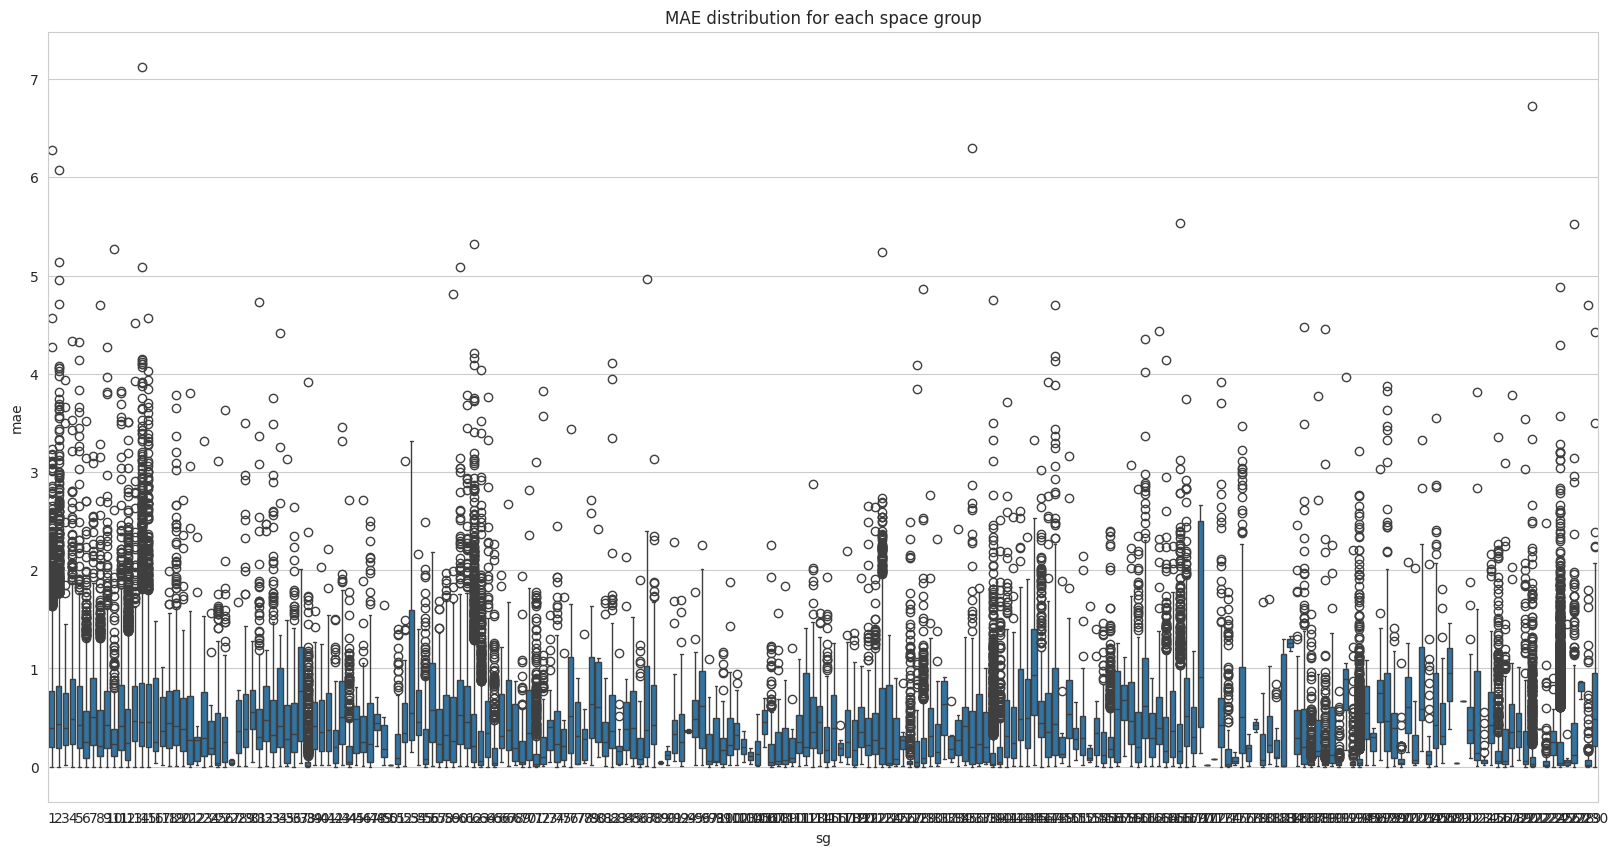

In [10]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=df)
plt.title("MAE distribution for each space group")
plt.show()

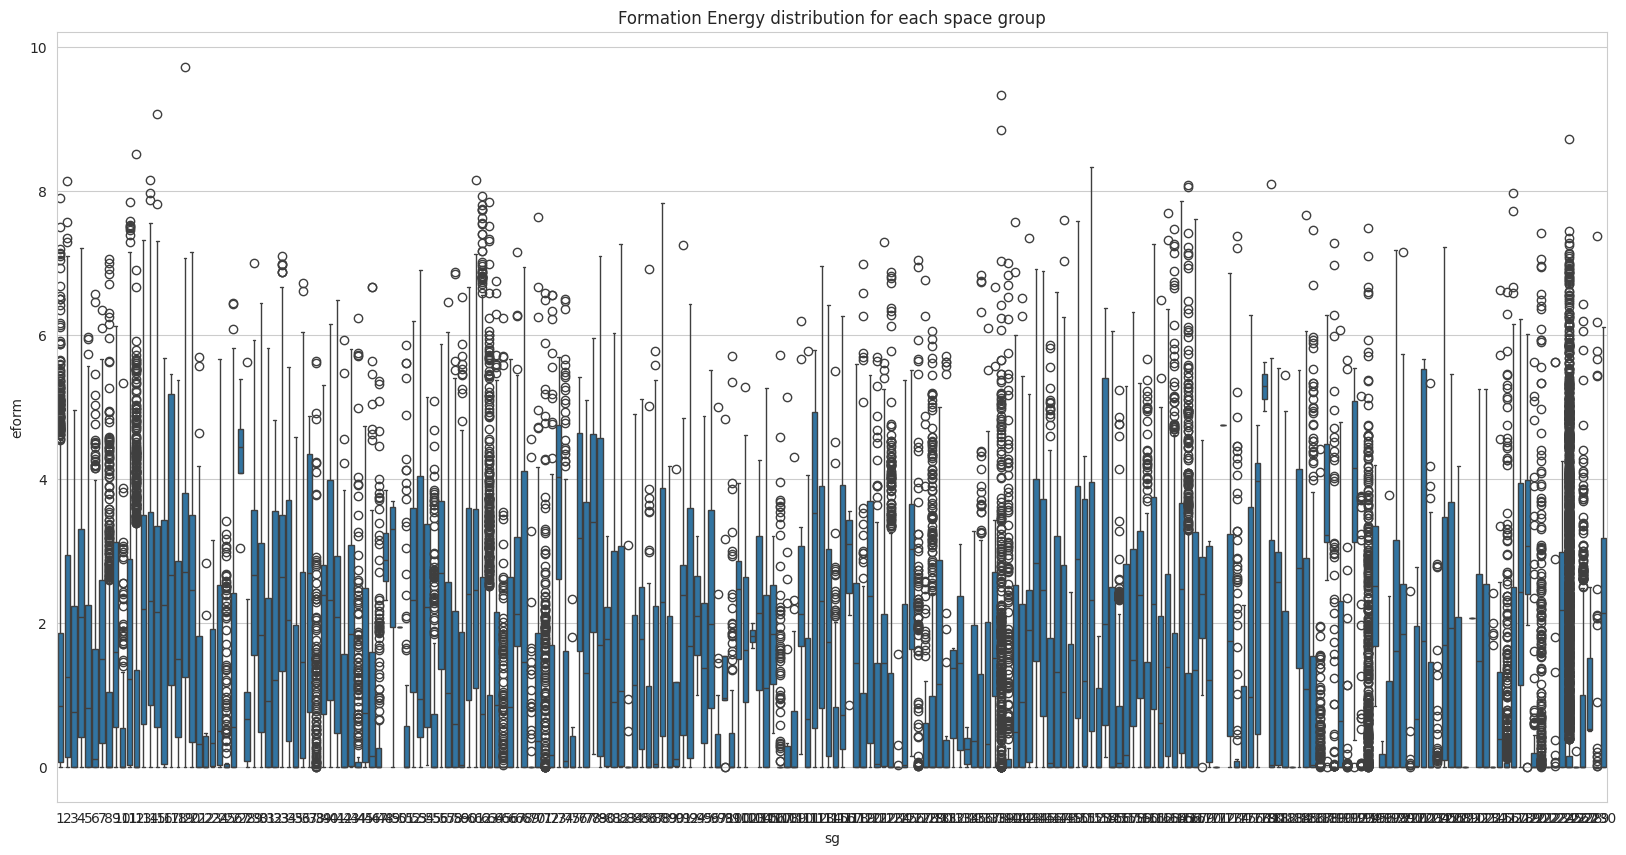

In [11]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="eform", data=df)
plt.title("Formation Energy distribution for each space group")
plt.show()

In [12]:
stats = df[["sg", "mae", "eform"]].groupby("sg").describe()
stats

mae                                                              \
      count      mean       std       min       25%       50%       75%   
sg                                                                        
1    5677.0  0.545267  0.495122  0.000170  0.197124  0.390266  0.771698   
2    4003.0  0.591428  0.569940  0.000065  0.193092  0.430600  0.821788   
3     147.0  0.590727  0.629779  0.013630  0.223707  0.394465  0.750069   
4     968.0  0.635397  0.561125  0.000015  0.229513  0.489256  0.897205   
5     827.0  0.583682  0.574507  0.000248  0.188833  0.425507  0.826432   
..      ...       ...       ...       ...       ...       ...       ...   
226    28.0  0.104886  0.272019  0.011991  0.016392  0.049251  0.072990   
227   571.0  0.327951  0.500007  0.000311  0.032803  0.122018  0.442258   
228     3.0  0.807643  0.099701  0.692816  0.775354  0.857892  0.865056   
229   148.0  0.163475  0.491006  0.000778  0.009304  0.021637  0.066549   
230   179.0  0.677795  0.640596  0.001614  0.207162  0.489843  0.958103   

                eform                                                 \
          max   count      mean       std     min       25%      50%   
sg                                                                     
1    6.276246  5677.0  1.211953  1.290914  0.0000  0.060500  0.84980   
2    6.070638  4003.0  1.687674  1.619145  0.0000  0.130600  1.24340   
3    3.932072   147.0  1.296310  1.377593  0.0000  0.000400  0.75590   
4    4.336000   968.0  2.133005  1.757747  0.0000  0.417975  2.08005   
5    4.320843   827.0  1.345464  1.475778  0.0000  0.000000  0.81810   
..        ...     ...       ...       ...     ...       ...      ...   
226  1.457173    28.0  0.007821  0.041387  0.0000  0.000000  0.00000   
227  5.525826   571.0  0.662522  1.182738  0.0000  0.000000  0.00000   
228  0.872220     3.0  1.172767  1.150016  0.4954  0.508850  0.52230   
229  4.702739   148.0  0.326622  1.237700  0.0000  0.000000  0.00000   
230  4.429474   179.0  1.879964  1.627367  0.0000  0.000000  2.13830   

                       
          75%     max  
sg                     
1    1.852800  7.8926  
2    2.934100  8.1320  
3    2.231850  4.9487  
4    3.298325  7.1994  
5    2.251050  5.9617  
..        ...     ...  
226  0.000000  0.2190  
227  0.996250  6.4233  
228  1.511450  2.5006  
229  0.000000  7.3713  
230  3.176750  6.1060  

[224 rows x 16 columns]

Text(0.5, 1.0, 'Space Group histogram')

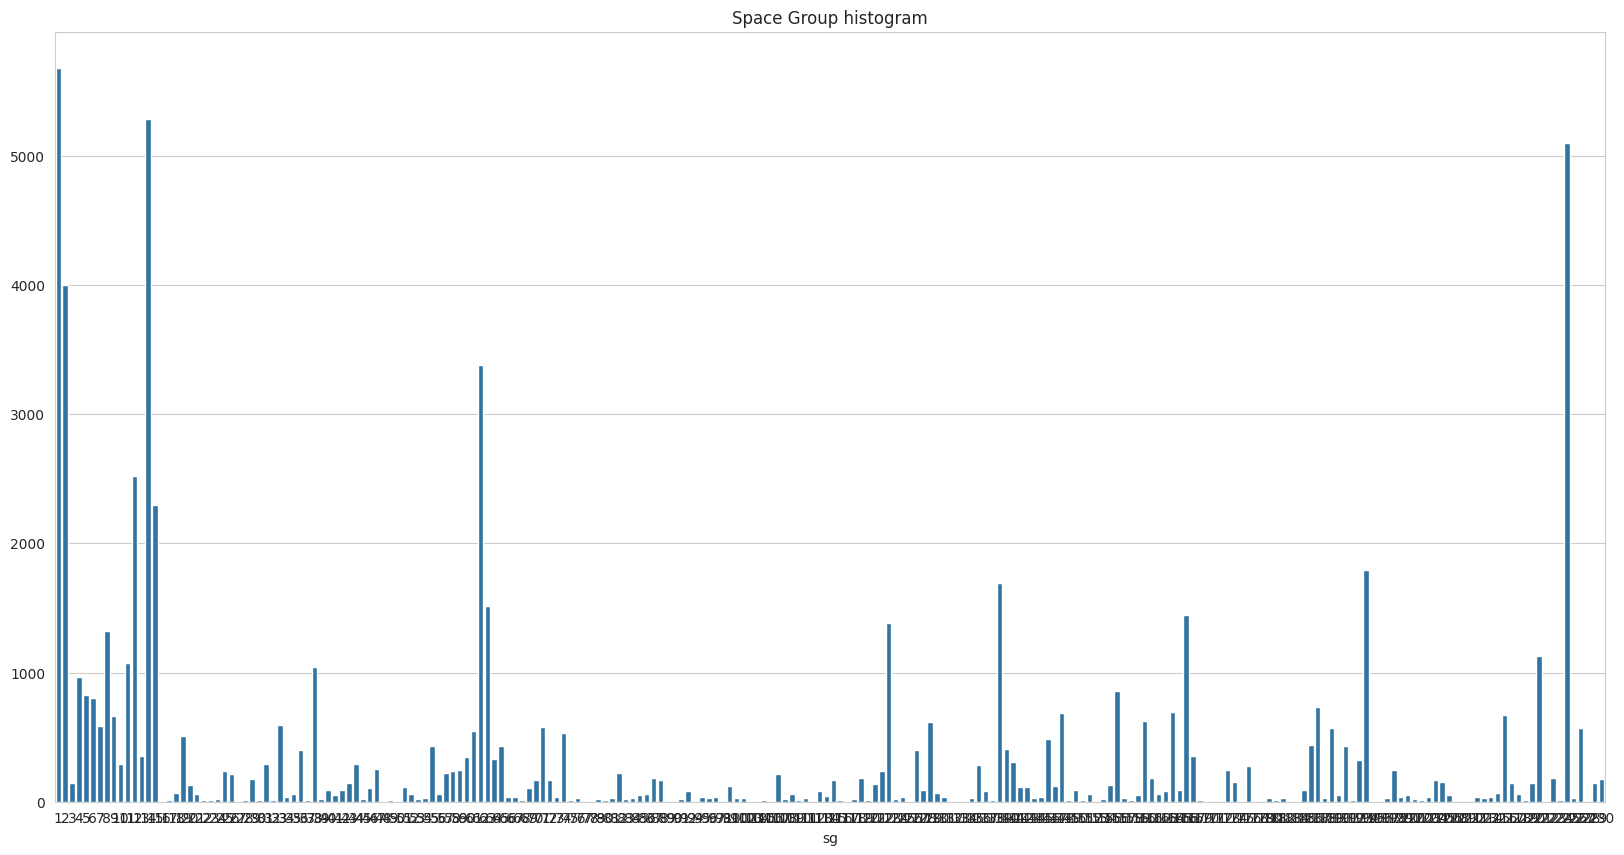

In [13]:
plt.figure(figsize=(20, 10))
sns.barplot(x=stats["mae"]["count"].index, y=stats["mae"]["count"].values)
plt.title("Space Group histogram")

In [14]:
mask = stats["eform"]["75%"] > 0
sg_pos = set(mask[mask].index)
print("Selecting space groups with Formation Energy 75% quantile > 0:", sg_pos, f"(n={mask.sum()})")

Selecting space groups with Formation Energy 75% quantile > 0: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 188, 190, 192, 195, 196, 197, 198, 199, 201, 202, 203, 205, 206, 208, 210, 212, 213, 215, 216, 217, 218, 219, 220, 224, 225, 227, 228, 230} (n=199)


In [15]:
# boxplot of the MAE distribution for each space group
double_df = df.copy()
double_df["sg"] = "all"
double_df = pd.concat([df.copy(), double_df])

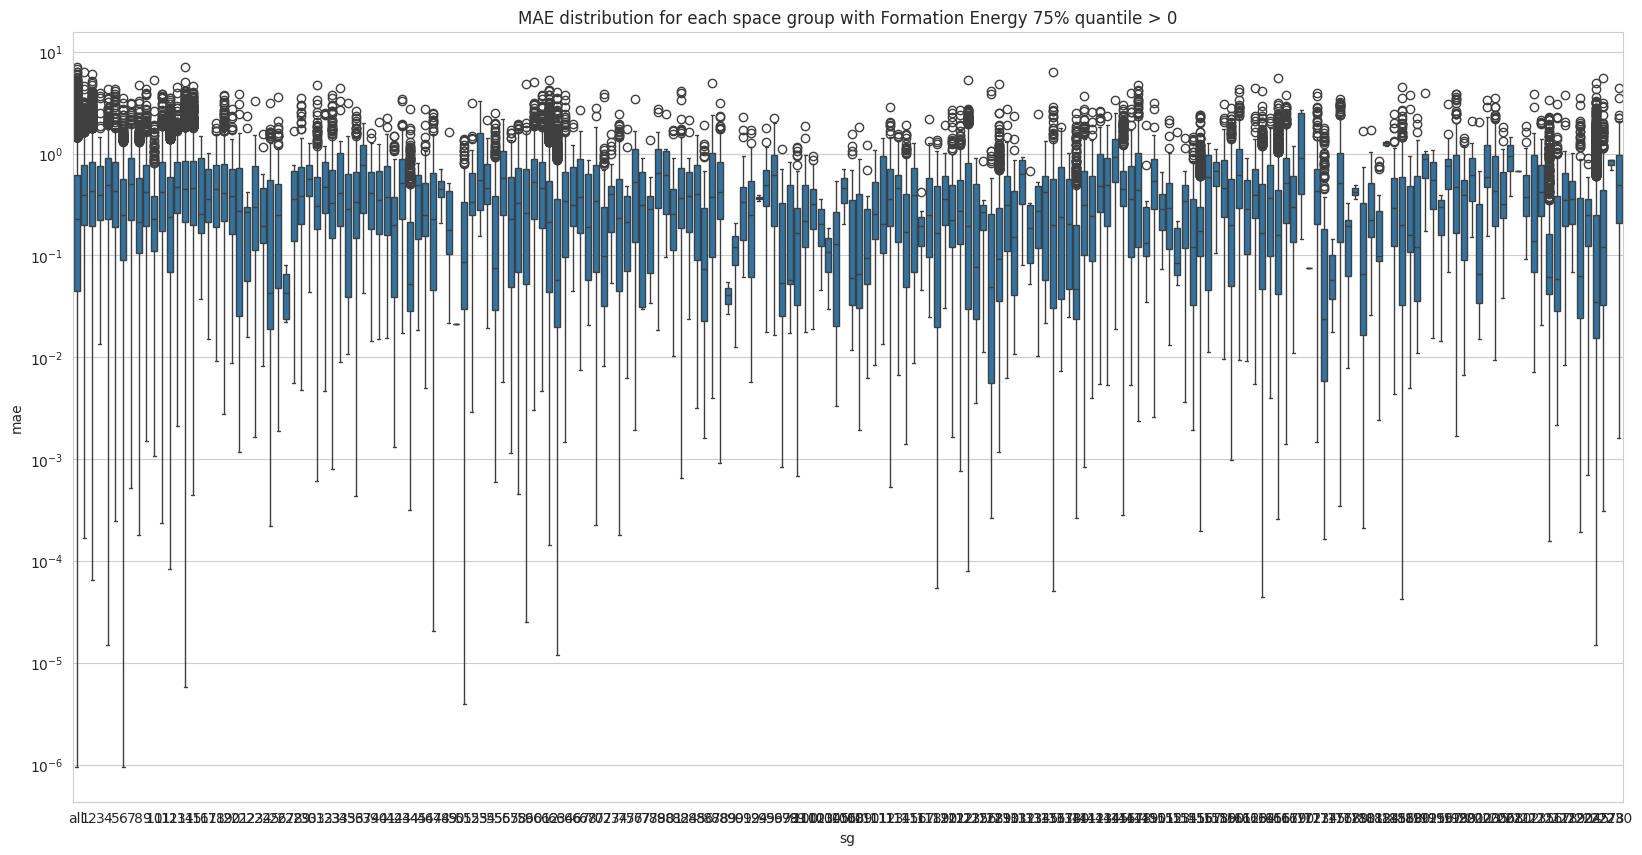

In [16]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=double_df[double_df["sg"].isin(sg_pos | set(["all"]))], order=["all"] + sorted(sg_pos))
plt.title("MAE distribution for each space group with Formation Energy 75% quantile > 0")
plt.yscale("log")
plt.show()

/tmp/ipykernel_630786/2413911832.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0, 10)
/tmp/ipykernel_630786/2413911832.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(0, 10)


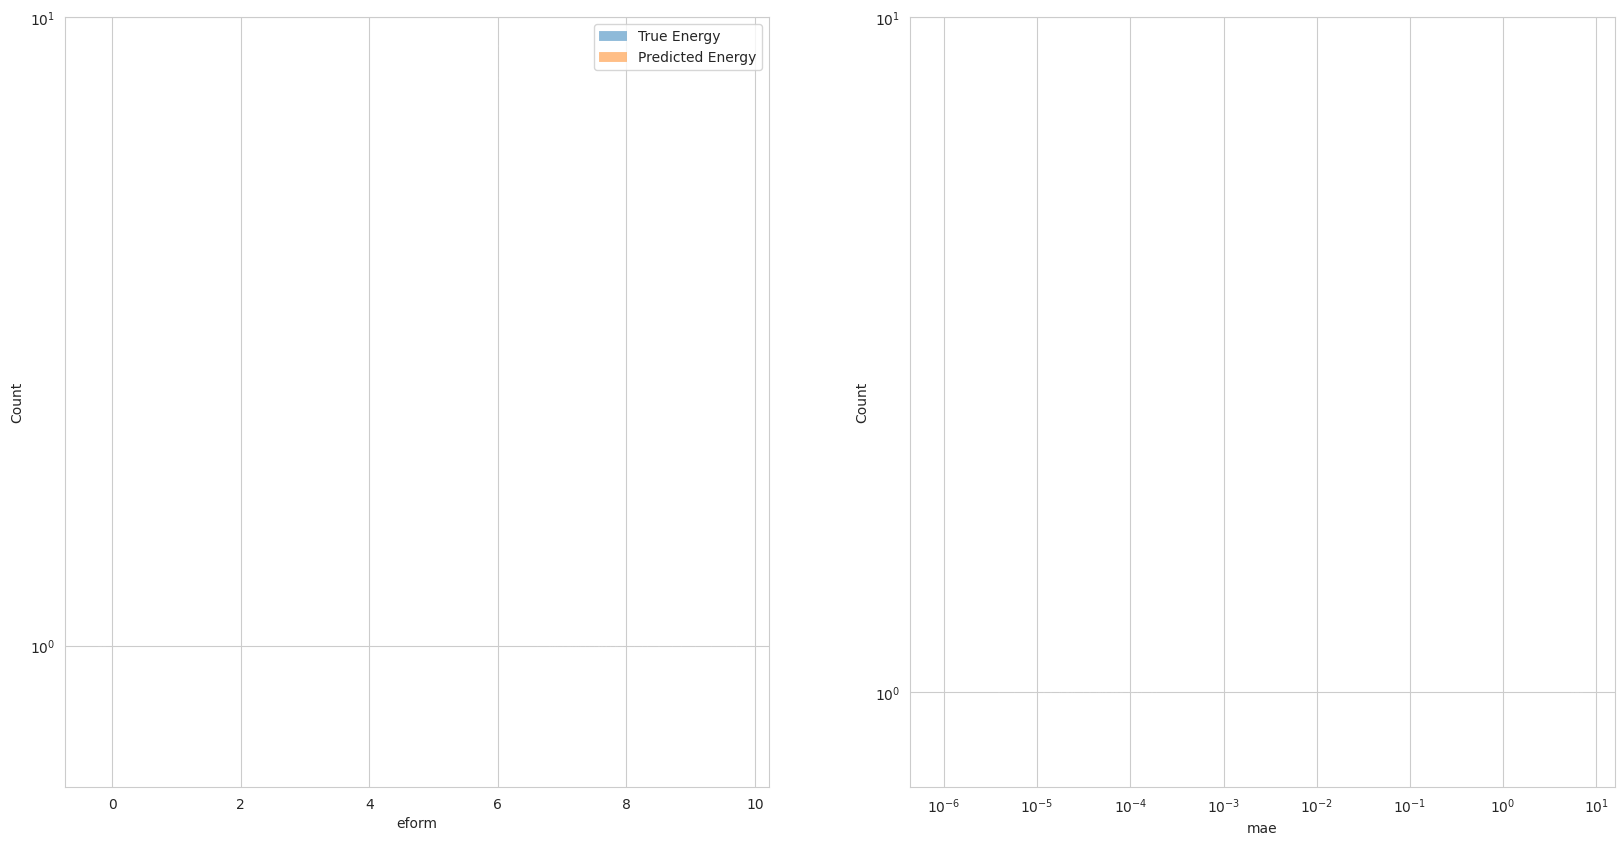

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(df["eform"], bins=500, log_scale=(False, True), ax=axs[0], label="True Energy", alpha=0.5)
sns.histplot(df["pred"], bins=500, log_scale=(False, True), ax=axs[0], label="Predicted Energy", alpha=0.5)
sns.histplot(df["mae"], label="MAE", bins=500, log_scale=(True, True), ax=axs[1])
axs[0].set_ylim(0, 10)
axs[1].set_ylim(0, 10)
axs[0].legend()

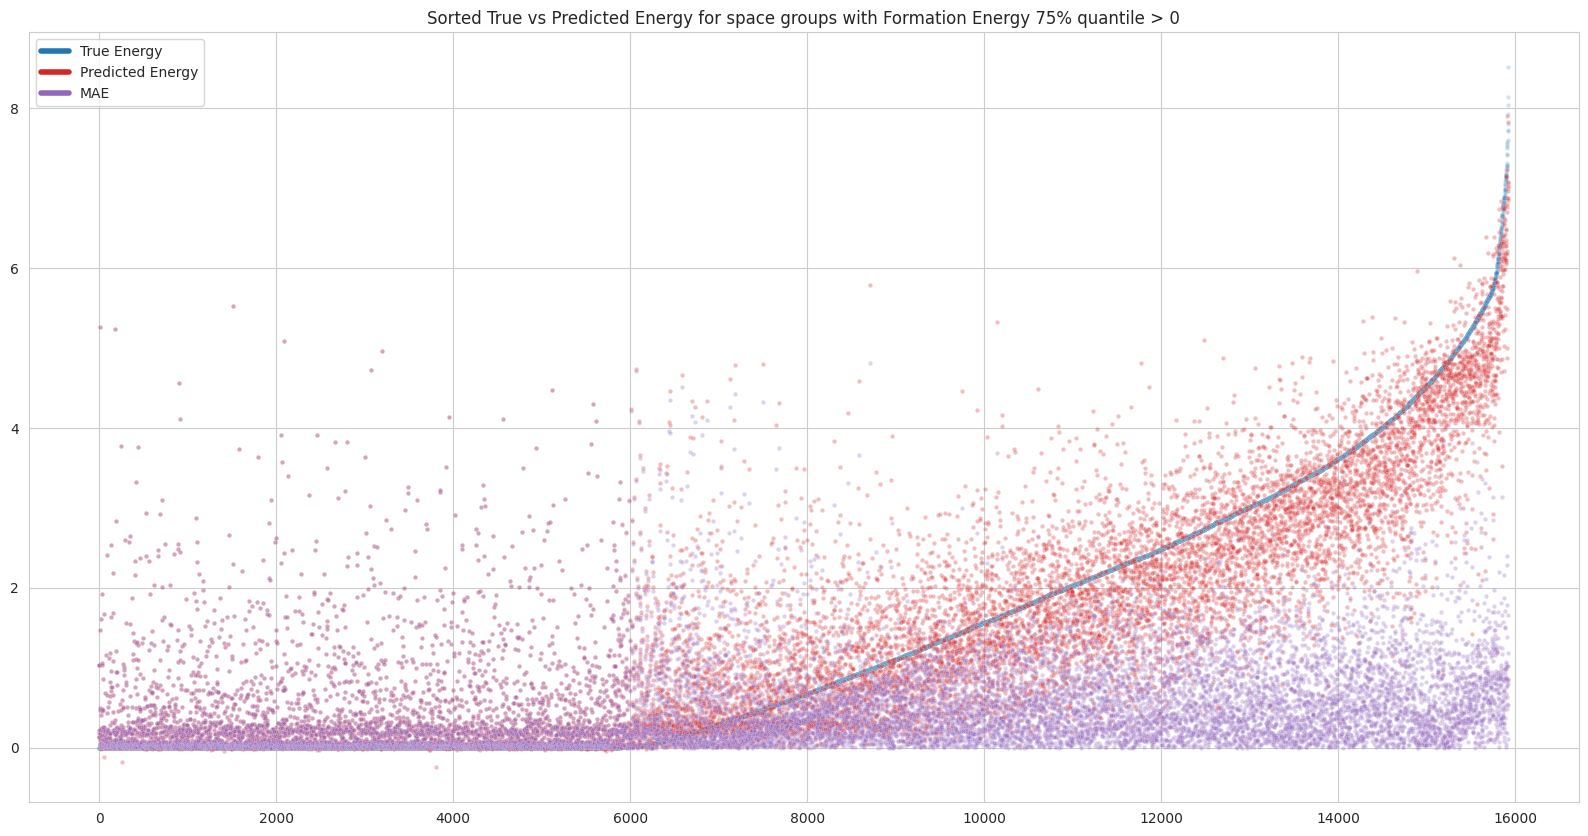

In [19]:
sorted_df = df[(df.dataset == "val") & (df.sg.isin(sg_pos))]
sort_idx = np.argsort(sorted_df["eform"].values)
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=np.arange(len(sorted_df)),
    y=sorted_df["eform"].values[sort_idx],
    label="True Energy",
    alpha=0.2,
    s=10,
)
sns.scatterplot(
    x=np.arange(len(sorted_df)),
    y=sorted_df["pred"].values[sort_idx],
    label="Predicted Energy",
    alpha=0.3,
    s=10,
    color="C3",
)
sns.scatterplot(
    x=np.arange(len(sorted_df)),
    y=sorted_df["mae"].values[sort_idx],
    label="MAE",
    alpha=0.3,
    s=10,
    color="C4",
)
plt.title("Sorted True vs Predicted Energy for space groups with Formation Energy 75% quantile > 0")
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", lw=4, label="True Energy"),
        plt.Line2D([0], [0], color="C3", lw=4, label="Predicted Energy"),
        plt.Line2D([0], [0], color="C4", lw=4, label="MAE"),
    ],
)

In [172]:
import matplotlib.gridspec as gridspec


def joint_plot(
    df,
    x,
    y,
    scale_kwarg={},
    labels={
        "mae": "MAE (eV)",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
):
    plt.figure(figsize=(10, 10))
    g = sns.JointGrid(data=df, x=x, y=y, marginal_ticks=True)
    g.ax_joint.set(**scale_kwarg)
    g.plot_joint(
        sns.histplot,
        discrete=(False, False),
        cmap="light:#03012d",
        pmax=0.8,
        bins=500,
    )
    g.plot_marginals(sns.histplot, element="step", color="#03012d")
    g.set_axis_labels(xlabel=labels[x], ylabel=labels[y])
    return g

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

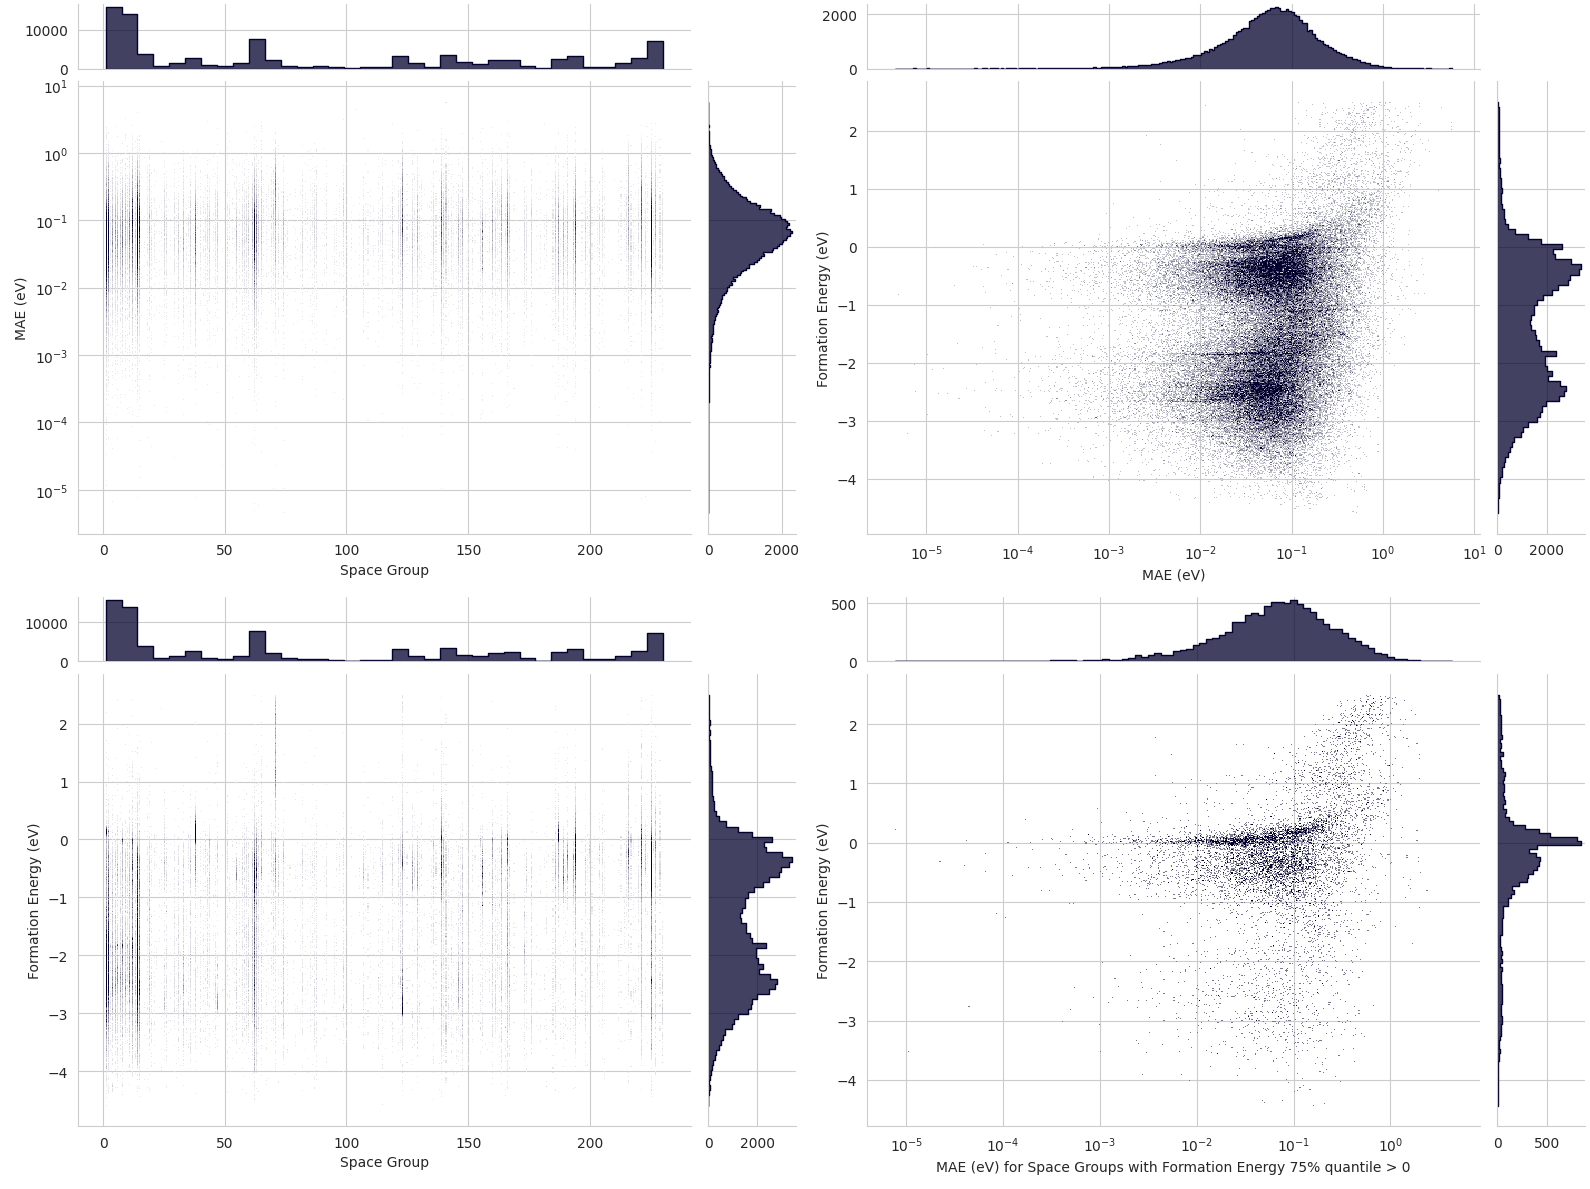

In [156]:
g0 = joint_plot(df, "sg", "mae", scale_kwarg={"yscale": "log"})
g1 = joint_plot(df, "sg", "eform")
g2 = joint_plot(df, "mae", "eform", scale_kwarg={"xscale": "log"})
g3 = joint_plot(
    df[df.sg.isin(sg_pos)],
    "mae",
    "eform",
    scale_kwarg={"xscale": "log"},
    labels={
        "mae": "MAE (eV) for Space Groups with Formation Energy 75% quantile > 0",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
)

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg2 = SeabornFig2Grid(g1, fig, gs[2])

mg1 = SeabornFig2Grid(g2, fig, gs[1])
mg3 = SeabornFig2Grid(g3, fig, gs[3])


gs.tight_layout(fig)
# gs.update(top=0.7)

plt.savefig("plots/proxy_loss/mae_eform_jointplot.png", dpi=300)
plt.show()

In [71]:
loaders["train"].dataset.root


'/home/mila/s/schmidtv/ocp-project/ActiveLearningMaterials/dave/proxies/matbench_mp_e_form'

In [83]:
model.loaded_config["src"]

'$root/dave/proxies/matbench_mp_e_form'

In [157]:
df.to_csv("plots/proxy_loss/proxy_loss.csv", index=False)

In [158]:
sorted({194, 228, 38, 71, 104, 139, 216, 187})

[38, 71, 104, 139, 187, 194, 216, 228]